# KNN similarity search strategies

This code generates Fig. 8

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import json
import h5py
import os
import sys
from time import time
import warnings

# Ignore warnings as they just pollute the output
warnings.filterwarnings('ignore')

# Enable importing modules from the parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../experiments'))
if module_path not in sys.path:
    sys.path.append(module_path)

# DNase-seq 2011, hg19
bw = 'data/ENCFF158GBQ.bigWig'

## Download the data and the autoencoder

In [4]:
from download import download_encode_file, download_file
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True)
Path('models').mkdir(parents=True, exist_ok=True)

download_encode_file('ENCFF158GBQ.bigWig')

download_file(
    "https://zenodo.org/record/2609763/files/dnase_w-12000_r-100.h5?download=1",
    "dnase_w-12000_r-100.h5",
    dir="models"
)

File already exist. To overwrite pass `overwrite=True`
File already exist. To overwrite pass `overwrite=True`


## Helper methods

#### Simple kNN search

In [9]:
from scipy.spatial.distance import cdist

def knn(data, target_idx, k, metric='euclidean', sax = None, ignore: int = 0, sort_only: bool = False):
    """K nearest neighbors
    
    Find the `k` nearest neighbors of a 
    """
    
    target = data[target_idx]
    
    if sort_only:
        dist = data
    else:
        if sax is None:
            dist = cdist(data, target.reshape((1, target.size)), metric='euclidean').flatten()

        else:
            N = data.shape[0]
            dist = np.zeros(N)
            for i in range(N):
                dist[i] = sax.distance_sax(target, data[i])

    # Ensure that the target is always first
    dist[target_idx] = -1
    for i in range(1, ignore + 1):
        dist[min(target_idx + i, data.shape[0] - 1)] = -1
        dist[max(target_idx - i, 0)] = -1
    
    return np.argsort(dist)[1 + (2 * ignore):k + 1 + (2 * ignore)]

#### DTW distance

In [5]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from multiprocessing import Pool

def dtw(data, target_idx: int, n: int, target = None, return_all = False, print_progress: bool = False):
    N = data.shape[0]
    dist = np.zeros(N)
    
    if target is None:
        target = data[target_idx]
        
    p = ((np.arange(4) + 1) * (N // 4)).astype(int)
    
    for i in np.arange(N):
        if i in p and print_progress:
            print('.', end='', flush=True)
        d, _ = fastdtw(data[i], target, dist=euclidean)
        dist[i] = d
    
    if return_all:
        return dist
    
    return np.argsort(dist)[:n]

def pooled_dtw(data, target_idx: int, target = None, print_progress: bool = False, ignore: int = 0, num_threads: int = None):
    if target is None:
        target = data[target_idx]
    
    with Pool(num_threads) as pool:
        args = [[d, 0, -1, target, True, print_progress] for d in np.array_split(data, pool._processes)]
        return np.concatenate(pool.starmap(dtw, args))

#### Normalized cross correlation search

In [15]:
from scipy.signal import correlate

def norm(data, zero_norm: bool = False):
    mean = np.mean(data) if zero_norm else 0
    
    return (data - mean) / np.std(data)

def norm2d(data, zero_norm: bool = False):
    mean = np.mean(data, axis=1).reshape(-1, 1) if zero_norm else np.zeros((data.shape[0], 1))
    std = np.std(data, axis=1).reshape(-1, 1)
    
    return (data - mean) / std

def xcorrelation(data, template_idx, n, normalize=False, zero_normalize=False, ignore: int = 0):
    unknown = data
    template = data[template_idx]
    
    if norm:
        unknown = norm2d(unknown, zero_norm=zero_normalize)
        template = norm(template, zero_norm=zero_normalize)
        
    xcorr = np.apply_along_axis(lambda m: correlate(m, template, mode='full'), axis=1, arr=unknown)
    xcorr[np.where(np.isnan(xcorr))] = 0

    max_xcorr = np.nanmax(xcorr, axis=1)
    
    # Ensure that the target is always last
    max_xcorr[template_idx] = -1
    for i in range(1, ignore + 1):
        max_xcorr[min(template_idx + i, data.shape[0] - 1)] = -1
        max_xcorr[max(template_idx - i, 0)] = -1
    
    return np.argsort(max_xcorr)[::-1][:n]

# 12 KB Search

In [6]:
from server import bigwig

data_12kb = bigwig.chunk(bw, 12000, 100, 12000 / 6, ['chr1'], verbose=True)

Extracted 124621 windows from chr1 with a max value of 1.0.


/Users/Fritz/miniconda3/envs/px/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


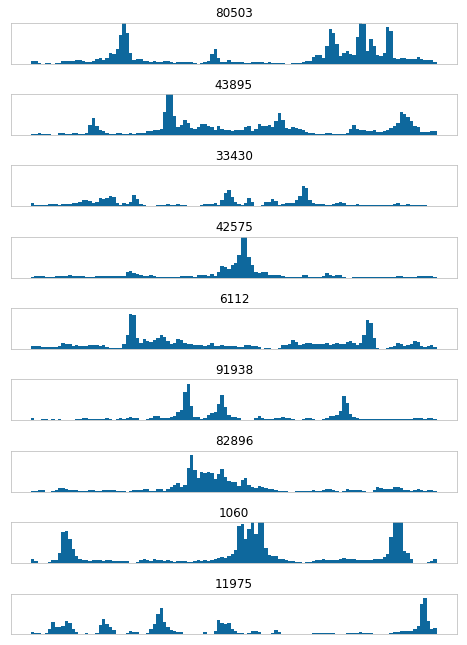

In [7]:
from ae.utils import plot_windows_from_data

k_12kb = 20 # Number of KNNs to be saved later on
targets_12kb = [80503, 43895, 33430, 42575, 6112, 91938, 82896, 1060, 11975]
targets_12kb_ex = 12933

plot_windows_from_data(data_12kb, window_ids=targets_12kb)

In [25]:
"""Compute the CAE latent space"""

from ae.utils import get_models, predict

encoder_12kb, decoder_12kb, autoencoder_12kb = get_models('models/dnase_w-12000_r-100.h5', loss_fn='bce')

t0 = time()
predicted_12kb, _, latent_12kb = predict(
    encoder_12kb,
    decoder_12kb,
    data_12kb.reshape(data_12kb.shape[0], data_12kb.shape[1], 1)
)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

with h5py.File('data/cae_12kb.h5', 'w') as f:
    f.create_dataset('latent_space', data=latent_12kb, dtype=np.float32)

Done! Took 16.13 seconds (0.3 minutes).


In [20]:
"""Compute UMAP embedding"""

import umap

t0 = time()
umap_embedding_12kb = umap.UMAP(
    n_neighbors=10,
    min_dist=0.01,
    metric='l2',
    n_components=10,
).fit_transform(data_12kb)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

with h5py.File('data/umap_12kb.h5', 'w') as f:
    f.create_dataset('umap', data=umap_embedding_12kb, dtype=np.float32)

Done! Took 366.94 seconds.


In [24]:
"""Compute TSFRESH"""

import h5py
import pandas as pd
from tsfresh import extract_features

N = data_12kb.shape[0]
L = data_12kb.shape[1]

tsfresh_12kb_df = pd.DataFrame(
    np.concatenate(
        (
            np.repeat(np.arange(data_12kb.shape[0]), data_12kb.shape[1]).reshape((-1, 1)),
            data_12kb.reshape((-1, 1)) 
        ),
        axis=1
    ),
    columns=['id', 'value']
)

batch_size = 1000

t0 = time()

with h5py.File('data/tsfresh_12kb.h5', 'w') as f:
    f.create_dataset('features', shape=(N, 794), dtype=np.float32)
    
    for i in np.arange(0, N, batch_size):
        batch = extract_features(
            tsfresh_12kb_df[i * L:(i + batch_size) * L],
            column_id='id',
            n_jobs=4,
        ).values

        f['features'][i:i + batch_size] = batch

print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Feature Extraction: 100%|██████████| 20/20 [01:36<00:00,  2.83s/it]


Done! Took 20275.21 seconds (337.9 minutes).


In [8]:
"""Conpute DTW"""

import umap

dtw_12kb = np.zeros((data_12kb.shape[0], len(targets_12kb)))
print('Compute DTW:')

t0 = time()
for i, target in enumerate(targets_12kb):
    t1 = time()
    dtw_12kb[:,i] = pooled_dtw(data_12kb, target)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    
print('All done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

with h5py.File('data/dtw_12kb.h5', 'w') as f:
    f.create_dataset('dtw', data=dtw_12kb, dtype=np.float32)

Compute DTW:
Target #0 done! Took 1405.44 seconds (23.4 minutes).
Target #1 done! Took 13959.86 seconds (232.7 minutes).
Target #2 done! Took 1345.71 seconds (22.4 minutes).
Target #3 done! Took 1370.74 seconds (22.8 minutes).
Target #4 done! Took 1340.71 seconds (22.3 minutes).
Target #5 done! Took 1358.93 seconds (22.6 minutes).
Target #6 done! Took 1363.71 seconds (22.7 minutes).
Target #7 done! Took 1403.97 seconds (23.4 minutes).
Target #8 done! Took 1384.14 seconds (23.1 minutes).
All done! Took 24933.23 seconds (415.6 minutes).


In [12]:
"""Compute SAX"""

from tslearn.piecewise import SymbolicAggregateApproximation

t0 = time()
sax_12kb = SymbolicAggregateApproximation(n_segments=120, alphabet_size_avg=10)
sax_data_12kb = sax_12kb.fit_transform(data_12kb)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Done! Took 2.83 seconds (0.0 minutes).


In [22]:
from time import time
    
with h5py.File('data/cae_12kb.h5', 'r') as f:
    cae_12kb = f['latent_space'][:]
    
with h5py.File('data/umap_12kb.h5', 'r') as f:
    umap_12kb = f['umap'][:]
    
with h5py.File('data/dtw_12kb.h5', 'r') as f:
    dtw_12kb = f['dtw'][:]

with h5py.File('data/tsfresh_12kb.h5', 'r') as f:
    tsfresh_12kb = f['features'][:]
    
    # Some features do not seem to computable. Lets set them to zero
    tsfresh_12kb[np.isnan(tsfresh_12kb)] = 0.0
    
with h5py.File('data/12kb-similarity-search.h5', 'w') as f:
    f.create_dataset('knn_ae', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_eq', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_sax', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_dtw', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_umap', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('knn_tsfresh', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    f.create_dataset('top_xcorr', shape=(len(targets_12kb), k_12kb), dtype=np.int)
    
    for i, target in enumerate(targets_12kb):
        t0 = time()
        print('Search for window #{}'.format(target), end='', flush=True)
        f['knn_ae'][i] = knn(cae_12kb, target, k_12kb, ignore=2)
        print('.', end='', flush=True)
        f['knn_eq'][i] = knn(data_12kb, target, k_12kb, ignore=2)
        print('.', end='', flush=True)
        f['knn_sax'][i] = knn(sax_data_12kb, target, k_12kb, sax=sax_12kb, ignore=2)
        print('.', end='', flush=True)
        f['knn_umap'][i] = knn(umap_12kb, target, k_12kb, ignore=2)
        print('.', end='', flush=True)
        f['top_xcorr'][i] = xcorrelation(data_12kb, target, k_12kb, normalize=True, zero_normalize=True, ignore=2)
        print('.', end='', flush=True)
        f['knn_tsfresh'][i] = knn(tsfresh_12kb, target, k_12kb)
        print('.', end='', flush=True)
        f['knn_dtw'][i] = knn(dtw_12kb[:,i], target, k_12kb, sort_only=True, ignore=2)
        print('. done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Search for window #80503....... done! Took 23.87 seconds (0.4 minutes).
Search for window #43895....... done! Took 22.83 seconds (0.4 minutes).
Search for window #33430....... done! Took 22.39 seconds (0.4 minutes).
Search for window #42575....... done! Took 24.29 seconds (0.4 minutes).
Search for window #6112....... done! Took 23.33 seconds (0.4 minutes).
Search for window #91938....... done! Took 22.10 seconds (0.4 minutes).
Search for window #82896....... done! Took 22.19 seconds (0.4 minutes).
Search for window #1060....... done! Took 23.13 seconds (0.4 minutes).
Search for window #11975....... done! Took 22.07 seconds (0.4 minutes).


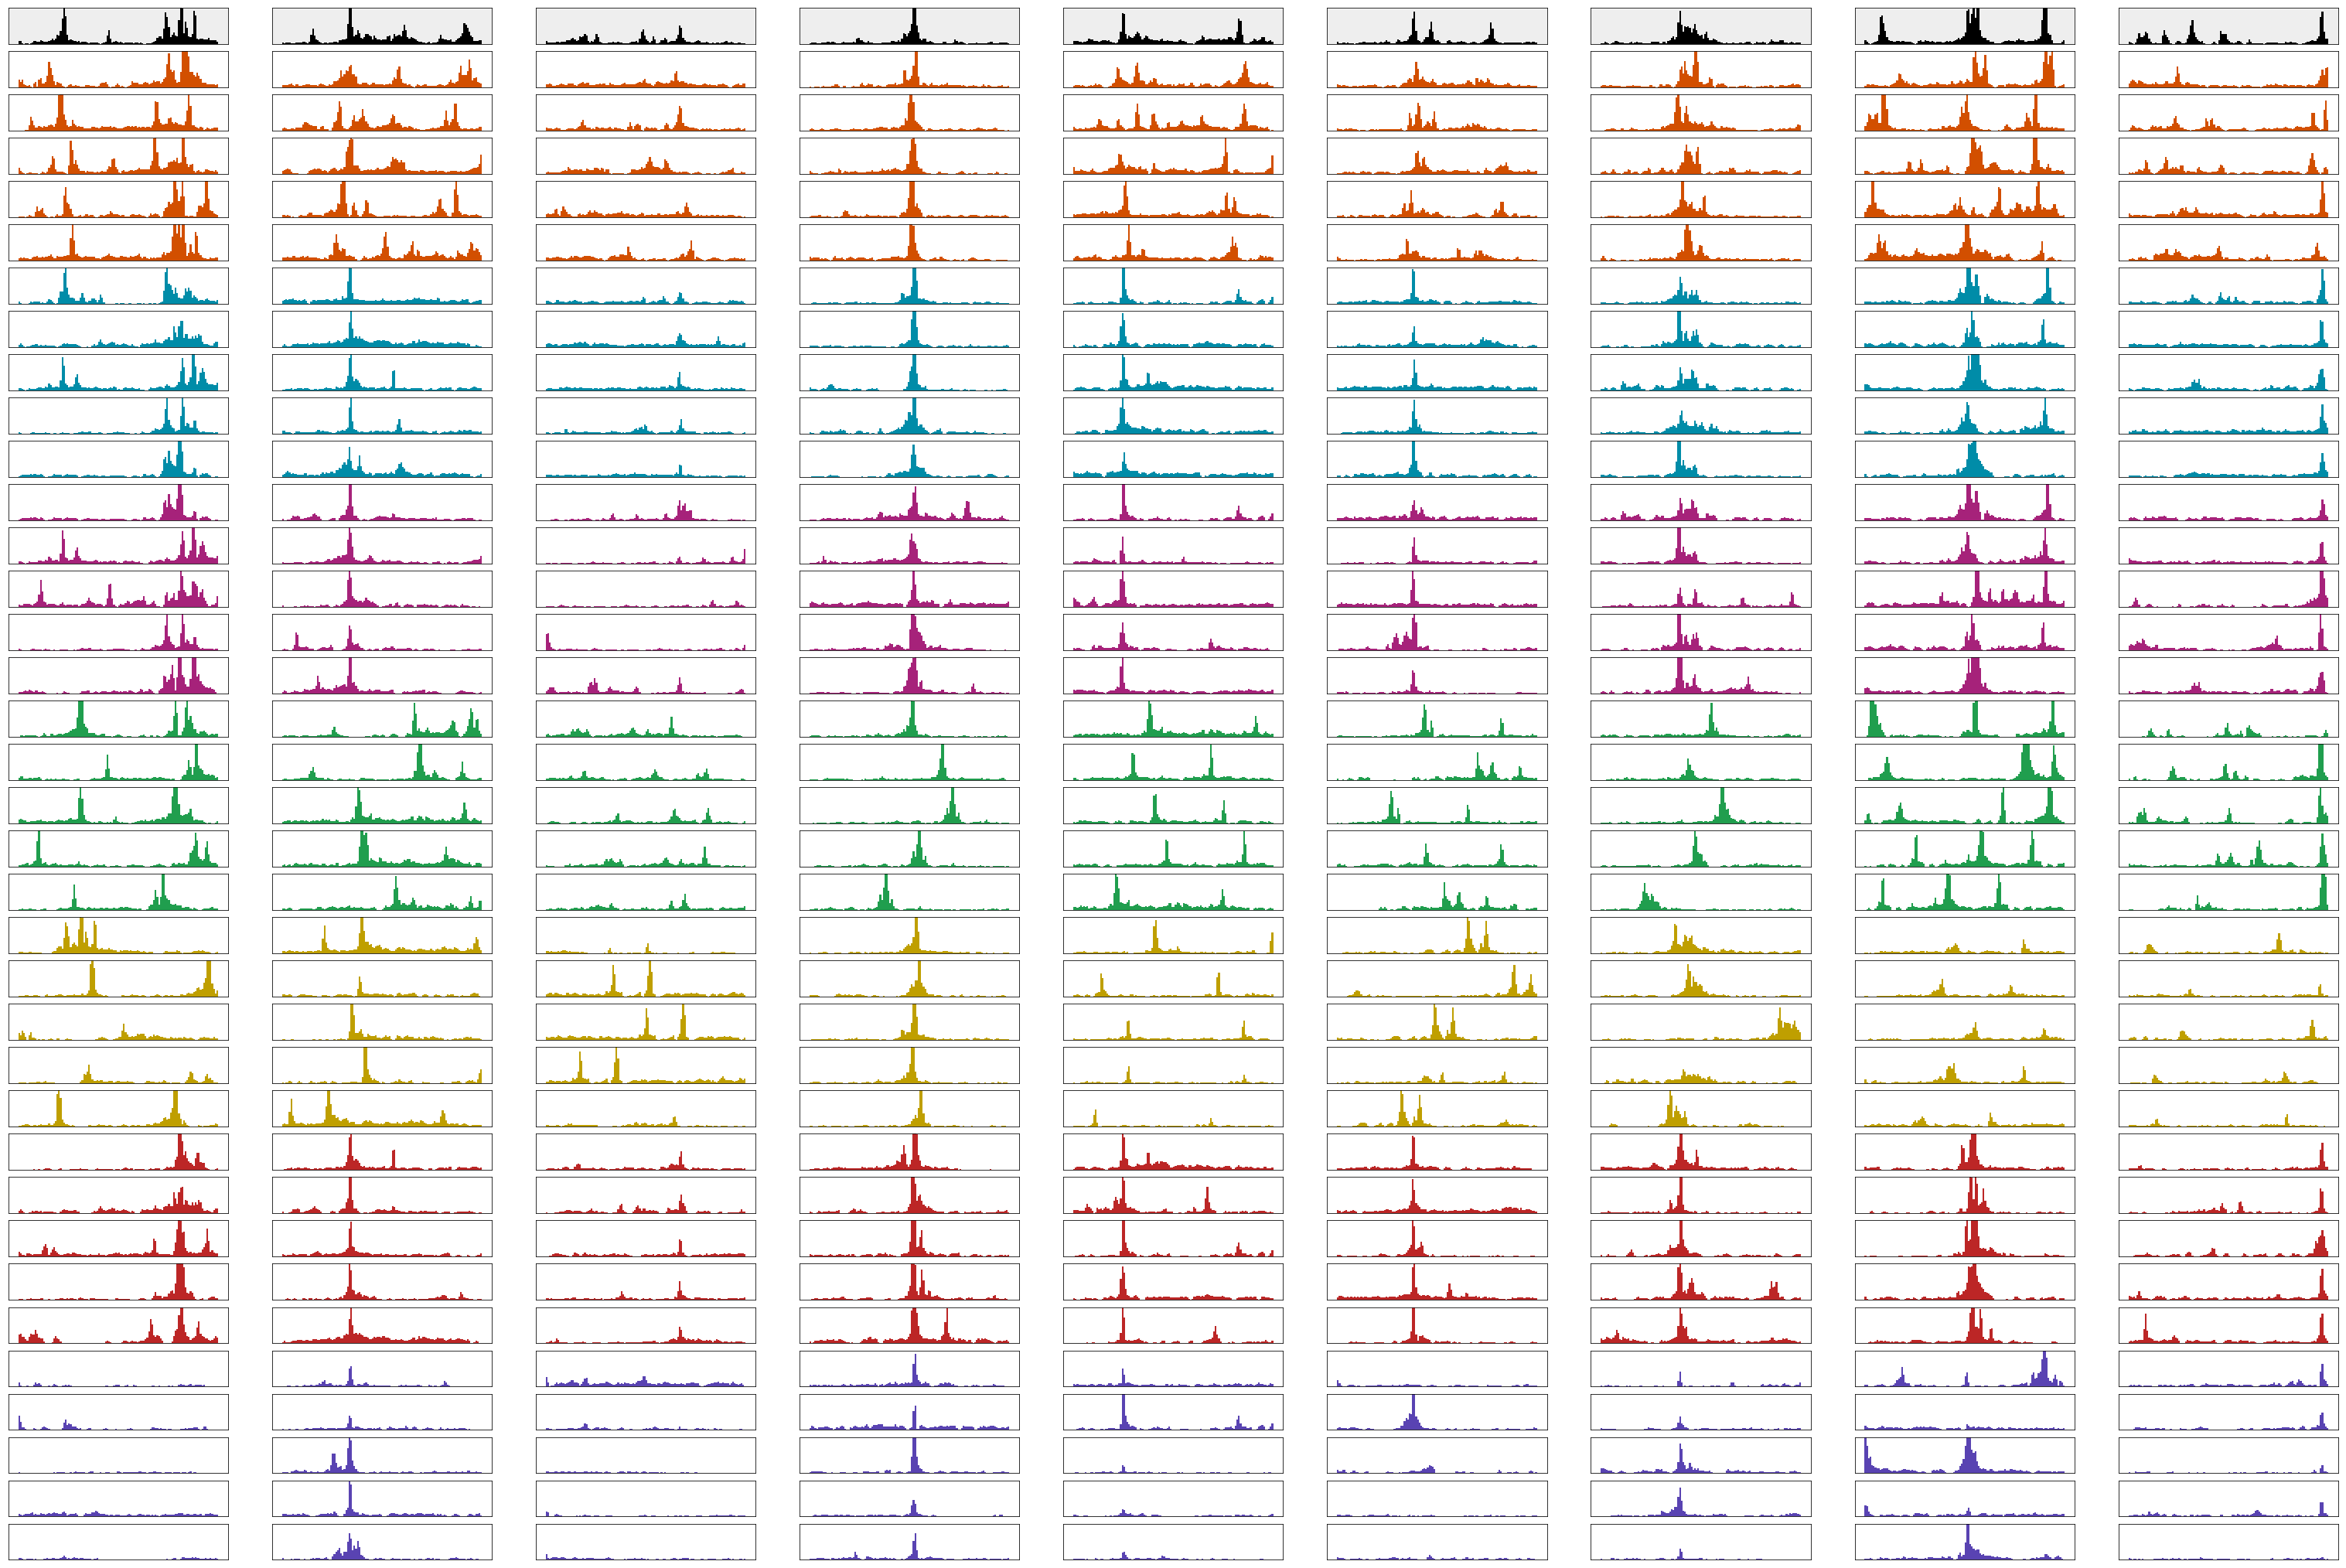

In [23]:
import h5py
import json
import matplotlib.pyplot as plt 
import numpy as np

with h5py.File('data/12kb-similarity-search.h5', 'r') as f:    
    knn_ae_12kb = f['knn_ae'][:]
    knn_eq_12kb = f['knn_eq'][:]
    knn_sax_12kb = f['knn_sax'][:]
    knn_dtw_12kb = f['knn_dtw'][:]
    knn_umap_12kb = f['knn_umap'][:]
    knn_tsfresh_12kb = f['knn_tsfresh'][:]
    top_xcorr_12kb = f['top_xcorr'][:]

show = 5

N = (show + 1) * 7

T = len(targets_12kb)
sz = data_12kb[0].size

plt.figure(figsize=(6 * T, N))

ymax = 1.0

show_predictions = False

for i, target in enumerate(targets_12kb):
    ax = plt.subplot(N, T, (i + 1))
        
    ax.set_facecolor("#eeeeee")
    
    plt.bar(np.arange(sz), data_12kb[target], color='#000000', width=1.0)

    plt.ylim(0, ymax)
    plt.xticks([], [])
    plt.yticks([], [])

    for j, hit in enumerate(knn_ae_12kb[i][:show]):
        plt.subplot(N, T, ((j + 1) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#d24f00', width=1.0) # orange = CAE
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

    for j, hit in enumerate(knn_eq_12kb[i][:show]):
        plt.subplot(N, T, ((j + 6) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#008ca8', width=1.0) # blue = EQ
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_sax_12kb[i][:show]):
        plt.subplot(N, T, ((j + 11) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#a6227a', width=1.0) # purple = SAX
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_dtw_12kb[i][:show]):
        plt.subplot(N, T, ((j + 16) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#209e4e', width=1.0) # green = DTW
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(top_xcorr_12kb[i][:show]):
        plt.subplot(N, T, ((j + 21) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#bf9f00', width=1.0) # yellow = Zero-nornalized X correlation
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_umap_12kb[i][:show]):
        plt.subplot(N, T, ((j + 26) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#bc2626', width=1.0) # red = UMAP
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

    for j, hit in enumerate(knn_tsfresh_12kb[i][:show]):
        plt.subplot(N, T, ((j + 31) * T) + (i + 1))
        plt.bar(np.arange(sz), data_12kb[hit], color='#5943b2', width=1.0) # purple = tsfresh
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])